# How to use subgraphs

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>            
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#subgraphs">
                    Subgraphs
                </a>
            </li>
            <li>            
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#state">
                    State
                </a>
            </li>
        </ul>
    </p>
</div> 

[Subgraphs](https://langchain-ai.github.io/langgraph/concepts/low_level/#subgraphs) allow you to build complex systems with multiple components that are themselves graphs. A common use case for using subgraphs is building [multi-agent systems](https://langchain-ai.github.io/langgraph/concepts/multi_agent).

The main question when adding subgraphs is how the parent graph and subgraph communicate, i.e. how they pass the [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) between each other during the graph execution. There are two scenarios:

* parent graph and subgraph **share schema keys**. In this case, you can [add a node with the compiled subgraph](#add-a-node-with-the-compiled-subgraph)
* parent graph and subgraph have **different schemas**. In this case, you have to [add a node function that invokes the subgraph](#add-a-node-function-that-invokes-the-subgraph): this is useful when the parent graph and the subgraph have different state schemas and you need to transform state before or after calling the subgraph

Below we show to to add subgraphs for each scenario.

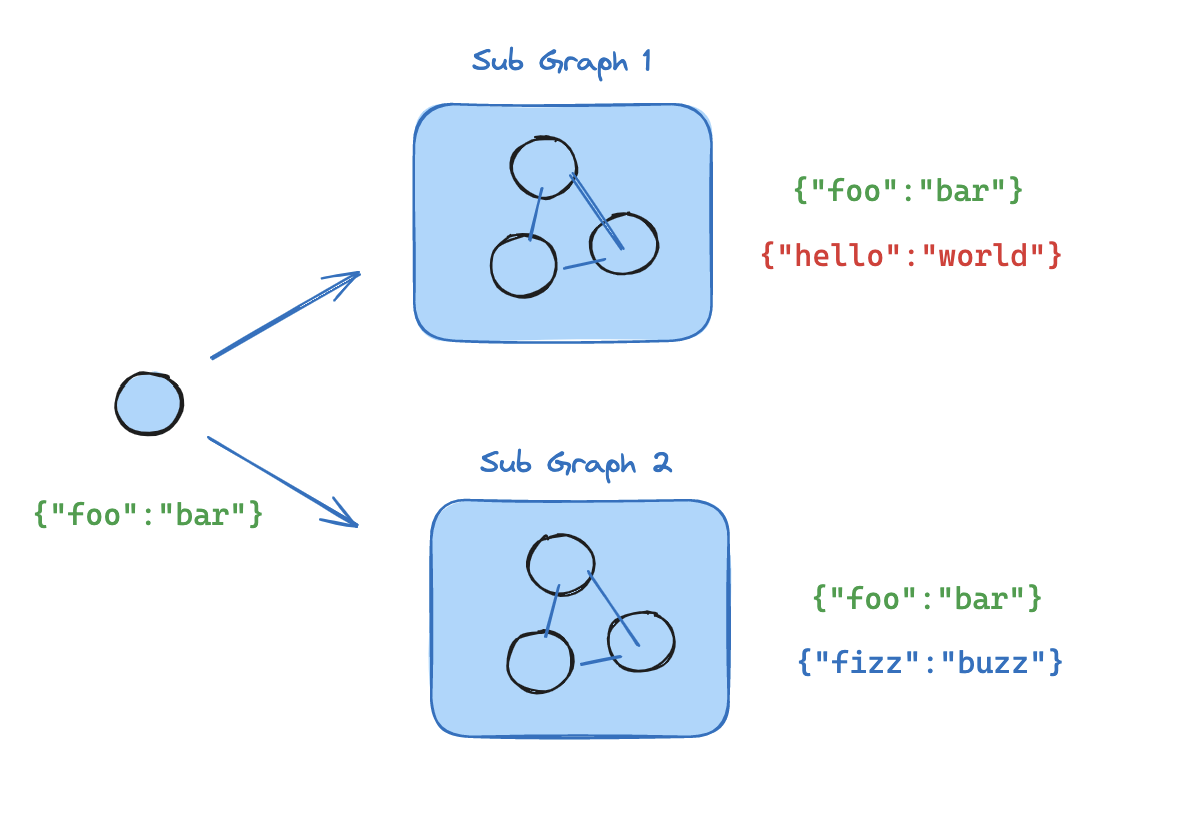

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Add a node with the compiled subgraph

A common case is for the parent graph and subgraph to communicate over a shared state key (channel). For example, in [multi-agent](https://langchain-ai.github.io/langgraph/concepts/multi_agent) systems, the agents often communicate over a shared [messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#why-use-messages) key.

If your subgraph shares state keys with the parent graph, you can follow these steps to add it to your graph:

1. Define the subgraph workflow (`subgraph_builder` in the example below) and compile it
2. Pass compiled subgraph to the `.add_node` method when defining the parent graph workflow

Let's take a look at a simple example. 

In [2]:
from langgraph.graph import START, StateGraph
from typing import TypedDict


# Define subgraph
class SubgraphState(TypedDict):
    foo: str  # note that this key is shared with the parent graph state
    bar: str


def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}


def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# Define parent graph
class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# note that we're adding the compiled subgraph as a node to the parent graph
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

In [3]:
for chunk in graph.stream({"foo": "foo"}):
    print(chunk)

{'node_1': {'foo': 'hi! foo'}}
{'node_2': {'foo': 'hi! foobar'}}


You can see that the final output from the parent graph includes the results of subgraph invocation (i.e. string `"bar"`). If you would like to see outputs from the subgraph, you can specify `subgraphs=True` when streaming. See more on streaming from subgraphs in this [how-to guide](https://langchain-ai.github.io/langgraph/how-tos/streaming-subgraphs/#stream-subgraph).

In [4]:
for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:e58e5673-a661-ebb0-70d4-e298a7fc28b7',), {'subgraph_node_1': {'bar': 'bar'}})
(('node_2:e58e5673-a661-ebb0-70d4-e298a7fc28b7',), {'subgraph_node_2': {'foo': 'hi! foobar'}})
((), {'node_2': {'foo': 'hi! foobar'}})


## Add a node function that invokes the subgraph

For more complex systems you might want to define subgraphs that have a completely different schema from the parent graph (no shared keys). For example, in a multi-agent RAG system, a search agent might only need to keep track of queries and retrieved documents.

If that's the case for your application, you need to define a node **function that invokes the subgraph**. This function needs to transform the input (parent) state to the subgraph state before invoking the subgraph, and transform the results back to the parent state before returning the state update from the node.

Below we show how to modify our original example to call a subgraph from inside the node.

!!! warning
    You **cannot** invoke more than one subgraph inside the same node.

In [5]:
# Define subgraph
class SubgraphState(TypedDict):
    # note that none of these keys are shared with the parent graph state
    bar: str
    baz: str


def subgraph_node_1(state: SubgraphState):
    return {"baz": "baz"}


def subgraph_node_2(state: SubgraphState):
    return {"bar": state["bar"] + state["baz"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# Define parent graph
class ParentState(TypedDict):
    foo: str


def node_1(state: ParentState):
    return {"foo": "hi! " + state["foo"]}


def node_2(state: ParentState):
    # transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # transform response back to the parent state
    return {"foo": response["bar"]}


builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# note that instead of using the compiled subgraph we are using `node_2` function that is calling the subgraph
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
graph = builder.compile()

In [6]:
for chunk in graph.stream({"foo": "foo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'foo': 'hi! foo'}})
(('node_2:c47d7ea3-7798-87c4-adf4-2543a91d6891',), {'subgraph_node_1': {'baz': 'baz'}})
(('node_2:c47d7ea3-7798-87c4-adf4-2543a91d6891',), {'subgraph_node_2': {'bar': 'hi! foobaz'}})
((), {'node_2': {'foo': 'hi! foobaz'}})
